# REI 603M - Assignment 6
## Andri Freyr Viðarsson

### Model theft

Model theft is a growing concern in the field of ML. When you release a model and users
can interact with the model as they please, you risk leaking information about the model
to the user.
In some scenarios, the users can even infer something about the training data based
on your model behavior. This can be especially worrisome if your model is trained on
sensitive data.
This exercise (if successful) is meant to illustrate how easy it can be to steal models.

In this project an attempt to steal a model is made. A model for real estate evaluation is available at an endpoint, a collection of results from calls to the endpoint with sampled inputs is used as a basis to build a model that aims to replicate the original model.

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from tqdm import tqdm

In [2]:
features = {'MSSubClass': {'max': 190, 'min': 20, 'type': 'int64'},
 'LotFrontage': {'max': 313.0, 'min': 21.0, 'type': 'float64'},
 'LotArea': {'max': 215245, 'min': 1300, 'type': 'int64'},
 'OverallQual': {'max': 10, 'min': 1, 'type': 'int64'},
 'OverallCond': {'max': 9, 'min': 1, 'type': 'int64'},
 'YearBuilt': {'max': 2010, 'min': 1872, 'type': 'int64'},
 'YearRemodAdd': {'max': 2010, 'min': 1950, 'type': 'int64'},
 'MasVnrArea': {'max': 1600.0, 'min': 0.0, 'type': 'float64'},
 'BsmtFinSF1': {'max': 5644, 'min': 0, 'type': 'int64'},
 'BsmtFinSF2': {'max': 1474, 'min': 0, 'type': 'int64'},
 'BsmtUnfSF': {'max': 2336, 'min': 0, 'type': 'int64'},
 'TotalBsmtSF': {'max': 6110, 'min': 0, 'type': 'int64'},
 '1stFlrSF': {'max': 4692, 'min': 334, 'type': 'int64'},
 '2ndFlrSF': {'max': 2065, 'min': 0, 'type': 'int64'},
 'LowQualFinSF': {'max': 572, 'min': 0, 'type': 'int64'},
 'GrLivArea': {'max': 5642, 'min': 334, 'type': 'int64'},
 'BsmtFullBath': {'max': 3, 'min': 0, 'type': 'int64'},
 'BsmtHalfBath': {'max': 2, 'min': 0, 'type': 'int64'},
 'FullBath': {'max': 3, 'min': 0, 'type': 'int64'},
 'HalfBath': {'max': 2, 'min': 0, 'type': 'int64'},
 'BedroomAbvGr': {'max': 8, 'min': 0, 'type': 'int64'},
 'KitchenAbvGr': {'max': 3, 'min': 0, 'type': 'int64'},
 'TotRmsAbvGrd': {'max': 14, 'min': 2, 'type': 'int64'},
 'Fireplaces': {'max': 3, 'min': 0, 'type': 'int64'},
 'GarageYrBlt': {'max': 2010.0, 'min': 1900.0, 'type': 'float64'},
 'GarageCars': {'max': 4, 'min': 0, 'type': 'int64'},
 'GarageArea': {'max': 1418, 'min': 0, 'type': 'int64'},
 'WoodDeckSF': {'max': 857, 'min': 0, 'type': 'int64'},
 'OpenPorchSF': {'max': 547, 'min': 0, 'type': 'int64'},
 'EnclosedPorch': {'max': 552, 'min': 0, 'type': 'int64'},
 '3SsnPorch': {'max': 508, 'min': 0, 'type': 'int64'},
 'ScreenPorch': {'max': 480, 'min': 0, 'type': 'int64'},
 'PoolArea': {'max': 738, 'min': 0, 'type': 'int64'},
 'MiscVal': {'max': 15500, 'min': 0, 'type': 'int64'},
 'MoSold': {'max': 12, 'min': 1, 'type': 'int64'},
 'YrSold': {'max': 2010, 'min': 2006, 'type': 'int64'}}

## Data Sampling
Since some features vary alot I thought that taking a random sample between min and max for each feature would not reflect the training data well enough. Therefore I made an effort to sample the datapoints for some important features more realistically.
Other features are sampled using either a uniform distribution between min and max or a normal distribution with median = (min+max)/2.

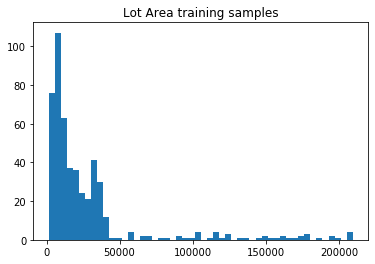

In [3]:
# generate probability distribution to sample lot area
# note that average lot area in US is around 12000
# a random sample from min-max is does not give a good representation
lot_range = np.linspace(features['LotArea']['min'], features['LotArea']['max'], 2500)
# 50 percent below 12000, 40% between 12000 and 40000, 10% between 30000 and max
n_1 = len(lot_range[(lot_range <12000)])
l_1 = lot_range[(lot_range<12000)]
l_2 = np.linspace(12000, 40000, n_1)
l_3 = np.linspace(40000, features['LotArea']['max'], n_1)

area_ls = list(l_1) + list(l_2) + list(l_3)
weights = [0.5/n_1 for i in range(n_1)]+[0.4/n_1 for i in range(n_1)]+[0.1/n_1 for i in range(n_1)]

lot_area_sampls = []
for i in range(500):
    lot_area_sampls.append(random.choices(area_ls, weights = weights)[0])
plt.hist(lot_area_sampls, bins = 50)
plt.title('Lot Area training samples')
plt.show()
lot_area_sampls.sort() # for indexing later on


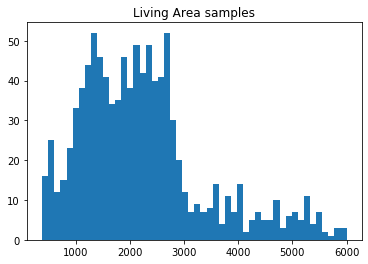

In [4]:
# average home_size is around 1800
# 10% between 350/800 sf , 70% between 800 and 3000 sf, 20% between 3000 and 6000 sf
l_1 = np.linspace(350, 1000,100)
l_2 = np.linspace(1000, 3000,100)
l_3 = np.linspace(3000, 6000, 100)
w = [0.1/100 for i in range(100)]+[0.7/100 for i in range(100)]+[0.2/100 for i in range(100)]
house_area = list(l_1)+list(l_2)+list(l_3)
house_area_sampls = [] # both floors
gr_area_sampls = []
for i in range(1000):
    area_s = random.choices(house_area, w)[0]
    if area_s > 1300 and random.uniform(0,1)>0.4:
        # add story
        house_area_sampls.append((random.uniform(0.9,1)*area_s/2, random.uniform(0.7,1)*area_s/2))
    else:
        house_area_sampls.append((area_s,0))
    gr_area_sampls.append(sum(house_area_sampls[-1]))

gr_area_sampls.sort()
house_area_sampls.sort(key = lambda k:sum(k))
plt.hist(gr_area_sampls, bins = 50)
plt.title('Living Area samples')
plt.show()

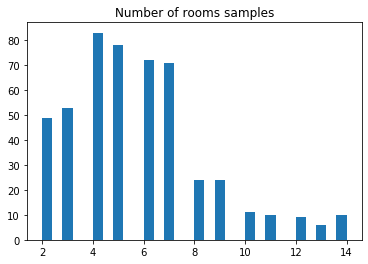

In [5]:
# 4-6 rooms is common
n_rooms = range(2,15)
rooms_w = [0.2/2]*2+[0.6/4]*4+[0.1/2]*2+[0.1/5]*5
rooms_sampl = [random.choices(n_rooms, rooms_w)[0] for i in range(500)]
rooms_sampl.sort()
plt.hist(rooms_sampl,bins = 30)
plt.title('Number of rooms samples')
plt.show()

In [6]:
def set_normal_params(min_,max_):
    med = (min_+max_)/2
    sd = med - (min_+med)/2
    return med, sd/2

def sample_feature_norm(feature):
    med, sd = set_normal_params(features[feature]['min'], features[feature]['max'])
    sample = np.random.normal(med, sd)
    if sample > features[feature]['max']:
        return features[feature]['max']
    if sample < features[feature]['min']:
        return features[feature]['min']
    return sample

def sample_small(feature):
    return random.randint(features[feature]['min'], features[feature]['max'])

## Handling correlated data
I assume that some features are very correlated, e.g. Living Area and total number of rooms. Therefore when generating a training data set samples with relatively simalar position in sorted sample vectors are put together to make each sample in the final training dataset with some added noise. Other features, such as YrSold, and OverallCond are selected at random.

In [7]:
vars_not_correlated = ['YrSold', 'MoSold','OverallQual', 'OverallCond', 'YearBuilt', 'GarageYrBlt']
samples_dict = {f:[] for f in features.keys()}
samples_dict['LotArea'] = lot_area_sampls
samples_dict['GrLivArea'] = gr_area_sampls
samples_dict['1stFlrSF'] = [i[0] for i in house_area_sampls]
samples_dict['2ndFlrSF'] = [i[1] for i in house_area_sampls]
samples_dict['TotRmsAbvGrd'] = rooms_sampl
samples_dict['BedroomAbvGr'] = [int(random.uniform(0.6,0.8)*i) for i in rooms_sampl]
samples_dict['TotalBsmtSF'] = [random.uniform(0,1)* i[0] for i in house_area_sampls]

for k in features.keys():
    if samples_dict[k] == []:
        for i in range(10000):
            if features[k]['max']-features[k]['min'] <=12:
                samples_dict[k].append(sample_small(k))
            else:
                samples_dict[k].append(sample_feature_norm(k))
        samples_dict[k].sort()

In [8]:
def make_sampl():
    params = {}
    n = len(gr_area_sampls)
    idx_lot = random.randint(0,n)
    for k, v in samples_dict.items():
        if k not in vars_not_correlated:
            index = int(random.uniform(0.8,1)*len(v)*(idx_lot/n))
            params[k] = int(v[index-1])
        else:
            index = random.randint(0, len(v)-1)
            params[k] = int(v[index-1])
    return params

def make_pred(params):
    r = requests.get('https://model-theft-bfcjj.ondigitalocean.app/model2', params = params)
    return float(r.content.decode('utf-8'))
    
p = make_sampl()
print(p)
make_pred(p)

{'MSSubClass': 107, 'LotFrontage': 177, 'LotArea': 17645, 'OverallQual': 10, 'OverallCond': 3, 'YearBuilt': 1954, 'YearRemodAdd': 1981, 'MasVnrArea': 847, 'BsmtFinSF1': 3058, 'BsmtFinSF2': 810, 'BsmtUnfSF': 1238, 'TotalBsmtSF': 153, '1stFlrSF': 2474, '2ndFlrSF': 1038, 'LowQualFinSF': 305, 'GrLivArea': 2174, 'BsmtFullBath': 2, 'BsmtHalfBath': 1, 'FullBath': 2, 'HalfBath': 1, 'BedroomAbvGr': 4, 'KitchenAbvGr': 2, 'TotRmsAbvGrd': 6, 'Fireplaces': 2, 'GarageYrBlt': 1940, 'GarageCars': 2, 'GarageArea': 771, 'WoodDeckSF': 465, 'OpenPorchSF': 298, 'EnclosedPorch': 286, '3SsnPorch': 279, 'ScreenPorch': 246, 'PoolArea': 407, 'MiscVal': 8424, 'MoSold': 10, 'YrSold': 2009}


329777.47

In [9]:
y = []
vals_ = []
for _ in tqdm(range(10000)):
    p = make_sampl()
    vals_.append(p)
    pred = make_pred(p)
    y.append(pred)
print(f'Min and Max preds for data samples {min(y)}, {max(y)}')

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [30:01<00:00,  5.55it/s]

Min and Max preds for data samples 42197.574, 444534.12


In [10]:
X = pd.DataFrame(vals_)
X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,69,104,2584,8,5,1933,1967,479,1694,440,...,417,249,154,165,148,143,220,4685,9,2008
1,106,174,19225,9,7,1937,1982,848,3022,755,...,746,438,294,289,259,256,384,8346,10,2009
2,95,149,9090,3,7,1946,1976,708,2513,646,...,616,377,235,247,228,211,329,6810,5,2007
3,81,128,5152,8,6,1920,1972,576,2096,548,...,517,311,200,202,185,180,268,5714,5,2007
4,48,67,1385,8,4,1926,1958,256,900,245,...,246,140,89,99,84,82,119,2577,9,2006


## Model Training
In the follwing chunks the attempt to 'steal' the model is made. 

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 123)

model = RandomForestRegressor(criterion = 'mae', max_depth = 8)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

print('Mean abs test error:', mean_absolute_error(y_test, y_pred))
print('Mean abs train error:', mean_absolute_error(y_train, y_pred_train))

Mean abs test error: 6624.0699476866685
Mean abs train error: 5759.487299352941


## Export stolen model

In [12]:
import pickle
filename = 'model_2_stolen.sav'
pickle.dump(model, open(filename, 'wb'))

In [13]:
loaded_model = pickle.load(open(filename, 'rb'))
y_p = loaded_model.predict(X_test)
print('Mean abs test error:', mean_absolute_error(y_test, y_p))

Mean abs test error: 6624.0699476866685
